Imports

In [290]:
import osmnx as ox
import requests
import pandas as pd
import matplotlib.pyplot as plt
import neo4j
print(neo4j.__version__)


5.28.1


setup for neo4j and some global functions

In [291]:
CYPHER_QUERY = """
MATCH (n) RETURN COUNT(n) AS node_count
"""
def get_node_count(tx):
    results  = tx.run(CYPHER_QUERY)
    df = results.to_df()
    return df

In [292]:
DELETE_NODES = """
MATCH (n)
DETACH DELETE n;
"""
def reset_database(tx):
    tx.run(DELETE_NODES)

    return 

In [293]:
NEO4J_URI = "bolt://localhost:7687/neo4j"
NEO4J_USER = "neo4j"
NEO4j_PASSWORD = "asdfasdf"

driver = neo4j.GraphDatabase.driver(NEO4J_URI,auth=(NEO4J_USER,NEO4j_PASSWORD))



with driver.session() as session:
    session.execute_write(reset_database)
    df = session.execute_read(get_node_count)
df

,node_count
0,0


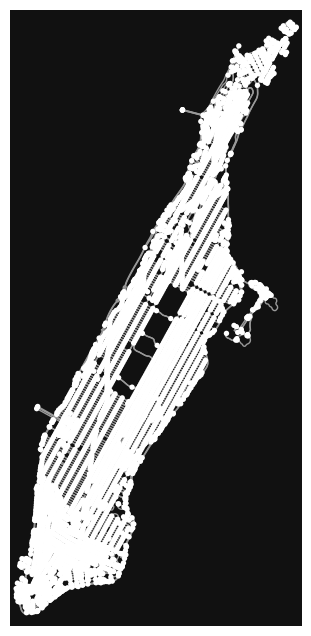

,osmid,y,x,highway,street_count,ref
0,42421728,40.798048,-73.960044,traffic_signals,3,NaN
1,42421731,40.798654,-73.961474,traffic_signals,4,NaN
2,42421737,40.799244,-73.962873,traffic_signals,4,NaN
3,42421741,40.800429,-73.965691,traffic_signals,4,NaN
4,42421745,40.801398,-73.967996,traffic_signals,4,NaN
...,...,...,...,...,...,...
4602,12534082089,40.801505,-73.960434,NaN,3,NaN
4603,12534082093,40.801204,-73.959615,traffic_signals,4,NaN
4604,12534082095,40.801112,-73.959682,traffic_signals,4,NaN
4605,12554607194,40.712465,-74.004865,traffic_signals,3,NaN


,u,v,key,osmid,highway,maxspeed,name,oneway,reversed,length,lanes,ref,access,bridge,tunnel,width,junction
0,42421728,42435337,0,195743153,secondary,25 mph,Central Park West,False,True,85.345155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42421728,42421731,0,"[420625565, 420625573, 5668966]",secondary,NaN,West 106th Street,False,False,138.033090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42421728,42432736,0,"[1271523197, 1271523198]",secondary,25 mph,Central Park West,False,False,86.274569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,42421731,42437916,0,5671485,residential,NaN,Manhattan Avenue,False,True,86.149203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42421731,42432737,0,195743186,residential,NaN,Manhattan Avenue,False,False,85.968765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,12534082095,42452290,0,"[1354419962, 1174924117]",secondary,25 mph,West 110th Street,True,False,115.067681,"[3, 2]",NaN,NaN,NaN,NaN,NaN,NaN
9884,12554607194,2821304146,0,507432922,secondary,20 mph,Centre Street,True,False,79.398439,1,NaN,NaN,NaN,NaN,NaN,NaN
9885,12554607194,4158740807,0,"[122660460, 122660459, 5669636, 1238347039]",trunk,30 mph,Brooklyn Bridge,True,False,158.817686,"[1, 2]",NaN,NaN,yes,NaN,NaN,NaN
9886,12663385194,42434559,0,"[517827497, 44164429, 377472336, 33146650, 331...",unclassified,NaN,Margaret Corbin Drive,False,"[False, True]",468.150361,2,NaN,NaN,yes,NaN,NaN,NaN


In [294]:
G = ox.graph_from_place("Manhattan, New York, NY, USA", network_type="drive")
fig, ax = ox.plot_graph(G)
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(G,node_geometry=False)
gdf_nodes.reset_index(inplace=True)
gdf_relationships.reset_index(inplace=True)
gdf_relationships=gdf_relationships.drop(columns=['geometry'])
display(gdf_nodes)
display(gdf_relationships)

In [295]:

constraint_query = "CREATE CONSTRAINT IF NOT EXISTS FOR (i:Intersection) REQUIRE i.osmid IS UNIQUE"

rel_index_query = "CREATE INDEX IF NOT EXISTS FOR ()-[r:ROAD_SEGMENT]-() ON r.osmids"

address_constraint_query = "CREATE CONSTRAINT IF NOT EXISTS FOR (p:POI) REQUIRE a.id IS UNIQUE"

point_index_query = "CREATE POINT INDEX IF NOT EXISTS FOR (i:Intersection) ON i.location"




node_query = '''
    UNWIND $rows AS row
    WITH row WHERE row.osmid IS NOT NULL
    MERGE (i:Intersection {osmid: row.osmid})
        SET i.location = 
         point({latitude: row.y, longitude: row.x }),
            i.ref = row.ref,
            i.highway = row.highway,
            i.street_count = toInteger(row.street_count)
    RETURN COUNT(*) as total
    '''


rels_query = '''
    UNWIND $rows AS road
    MATCH (u:Intersection {osmid: road.u})
    MATCH (v:Intersection {osmid: road.v})
    MERGE (u)-[r:ROAD_SEGMENT {osmid: road.osmid}]->(v)
        SET r.oneway = road.oneway,
            r.lanes = road.lanes,
            r.ref = road.ref,
            r.name = road.name,
            r.highway = road.highway,
            r.max_speed = road.maxspeed,
            r.length = toFloat(road.length)
    RETURN COUNT(*) AS total
    '''

Loading the data in in batches for efficiency 

In [296]:
def insert_constraints(tx):
    results = tx.run(constraint_query)
    results = tx.run(rel_index_query)
    results = tx.run(point_index_query)
    print(results)
def insert_data(tx, query, rows, batch_size=10000):
    total = 0
    batch = 0
    
    while batch * batch_size < len(rows):
        results = tx.run(query, parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')}).data()
        print(results)
        total += results[0]['total']
        batch += 1

Importing the street data into neo4j

In [297]:
# Run our constraints queries and nodes GeoDataFrame import

with driver.session() as session:
    session.execute_write(insert_constraints)
    session.execute_write(insert_data, node_query, gdf_nodes)

# Run our relationships GeoDataFrame import

with driver.session() as session:
    session.execute_write(insert_data, rels_query, gdf_relationships)

[{'total': 4607}]
[{'total': 9888}]


Now that we have the city mapped we can add POI's

In [298]:
query = '''
    /*
    This has been generated by the overpass-turbo wizard.
    The original search was:
    “tourism=* in Manhattan”
    */
    [out:csv( ::"id",::"type",::"lat",::"lon",name, tourism, wikipedia,"addr:housenumber","addr:street","addr:city","addr:state","addr:postcode";true;",")][timeout:25];
    // fetch area “Manhattan” to search in
    area(id:3608398124)->.searchArea;
    // gather results
    nwr["tourism"](area.searchArea);
    // print results
    out geom;
'''

response = requests.post(url='https://overpass-api.de/api/interpreter',data=query)
print(response.status_code)
print(response.text)
with open("data/OSM_Manhattan_POI.csv",'w',encoding='utf8') as file:
    file.write(str(response.text))
df = pd.read_csv('data/OSM_Manhattan_POI.csv',on_bad_lines='skip')
df.columns = df.columns.str.replace('@','',regex=False)
df.columns = df.columns.str.replace('addr:','',regex=False)

df.to_csv("data/CLEANED_OSM_Manhattan_POI.csv",index=False)


200
@id,@type,@lat,@lon,name,tourism,wikipedia,addr:housenumber,addr:street,addr:city,addr:state,addr:postcode
158801311,node,40.7251022,-73.9795833,Alphabet City,yes,,,,,,
158809984,node,40.7228800,-73.9987505,SoHo,attraction,"en:SoHo, Manhattan",,,,,
158862484,node,40.7486231,-73.9713889,Tudor City,yes,,,,,,
320948228,node,40.7057505,-74.0029056,South Street Seaport,attraction,en:South Street Seaport,,,,,
357618558,node,40.7322674,-73.9972548,"New York Studio School of Drawing, Painting and Sculpture",yes,"en:New York Studio School of Drawing, Painting and Sculpture",,,,,
357620718,node,40.7714555,-73.9679875,Richard Morris Hunt,artwork,en:Richard Morris Hunt Memorial,,,,,
357621823,node,40.7941111,-73.9764799,Joan of Arc Memorial,artwork,,,,,,
368042980,node,40.7214798,-73.9971028,Storefront for Art and Architecture,gallery,en:Storefront for Art and Architecture,97,Kenmare Street,,,10012
368043598,node,40.7338007,-74.0021484,Stonewall Inn,attraction,en:Stonewall Inn,53,Christopher S

In [299]:
response = requests.get('https://overpass-api.de/api/interpreter?data=%2F*%0AThis%20has%20been%20generated%20by%20the%20overpass-turbo%20wizard.%0AThe%20original%20search%20was%3A%0A%E2%80%9Ctourism%3D*%20in%20Manhattan%E2%80%9D%0A*%2F%0A%5Bout%3Ajson%5D%5Btimeout%3A25%5D%3B%0A%2F%2F%20fetch%20area%20%E2%80%9CManhattan%E2%80%9D%20to%20search%20in%0Aarea%28id%3A3608398124%29-%3E.searchArea%3B%0A%2F%2F%20gather%20results%0Anwr%5B%22tourism%22%5D%28area.searchArea%29%3B%0A%2F%2F%20print%20results%0Aout%20geom%3B')
print(response.status_code)
data = response.json()
with open("data/raw/OSM_Manhattan_Tourism",'w',encoding='utf8') as file:
    file.write(str(data))

200


Now we have formatted POI's we can add to the database

In [300]:

poi_query = '''
   load csv with headers from 'file:///CLEANED_OSM_Manhattan_POI.csv' as row 
    WITH row WHERE row.id IS NOT NULL
    MERGE (p:POI {osmid: row.id})
        SET p.location = 
         point({latitude: toFloat(row.lat), longitude: toFloat(row.lon) }),
            p.name = row.name,
            p.tourism_type = row.tourism,
            p.wikipedia = row.wikipedia,
            p.address_number = row.housenumber,
            p.address_street = row.street,
            p.address_city = "New York",
            p.address_state = "NY",
            p.address_zip = row.postcode
    RETURN COUNT(*) as total
'''

poi_rel_query = '''
    CALL apoc.periodic.iterate(
  'MATCH (p:POI) WHERE NOT EXISTS ((p)-[:NEAREST_INTERSECTION]->(:Intersection)) RETURN p',
  'CALL {
  WITH p
  MATCH (i:Intersection)
  USING INDEX i:Intersection(location)
  WHERE point.distance(i.location, p.location) < 200

  WITH i
  ORDER BY point.distance(p.location, i.location) ASC 
  LIMIT 1
  RETURN i
    }
    WITH p, i

    MERGE (p)-[r:NEAREST_INTERSECTION]->(i)
    SET r.length = point.distance(p.location, i.location)
    RETURN COUNT(p)',
    {batchSize:10000, parallel:false})
'''

In [301]:
driver.execute_query(poi_query)
driver.execute_query(poi_rel_query)

EagerResult(records=[<Record batches=1 total=1938 timeTaken=1 committedOperations=1938 failedOperations=0 failedBatches=0 retries=0 errorMessages={} batch={'total': 1, 'errors': {}, 'committed': 1, 'failed': 0} operations={'total': 1938, 'errors': {}, 'committed': 1938, 'failed': 0} wasTerminated=False failedParams={} updateStatistics={'relationshipsDeleted': 0, 'relationshipsCreated': 1799, 'nodesDeleted': 0, 'nodesCreated': 0, 'labelsRemoved': 0, 'labelsAdded': 0, 'propertiesSet': 1799}>], summary=<neo4j._work.summary.ResultSummary object at 0x0000015AFC6D2B40>, keys=['batches', 'total', 'timeTaken', 'committedOperations', 'failedOperations', 'failedBatches', 'retries', 'errorMessages', 'batch', 'operations', 'wasTerminated', 'failedParams', 'updateStatistics'])